In [1]:
# Source code for paper: "Searching of potentially anomalous signals in cosmic-ray particle tracks images using rough k-means clustering combined with eigendecomposition-derived embedding"
# Download and unzip data and sources
!wget https://github.com/browarsoftware/particle_pars/raw/master/data/credo_data.zip
!wget https://github.com/browarsoftware/particle_pars/raw/master/data/emb.npy
!wget https://github.com/browarsoftware/particle_pars/raw/master/data/image_files_list.txt
!wget https://raw.githubusercontent.com/browarsoftware/particle_pars/master/rkmeans/kmrs.py
!mkdir data
!unzip  -qq credo_data.zip -d data

--2023-08-18 15:29:48--  https://github.com/browarsoftware/particle_pars/raw/master/data/credo_data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/browarsoftware/particle_pars/master/data/credo_data.zip [following]
--2023-08-18 15:29:48--  https://raw.githubusercontent.com/browarsoftware/particle_pars/master/data/credo_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22820848 (22M) [application/zip]
Saving to: ‘credo_data.zip’

credo_data.zip      100%[===================>]  21.76M  --.-KB/s    in 0.07s   

2023-08-18 15:29:48 (317 MB/s) - ‘credo_data.zip’ saved [22820848/22820848]


In [2]:
# Preapare data
import numpy as np
# Open file with embedding
emb_array = np.load("/content/emb.npy")
print(emb_array.shape)

# Open file with dataset files names
my_file = open("/content/image_files_list.txt", "r")
data = my_file.read()
data_into_list = data.split("\n")
my_file.close()
# Import code for rough k-means
# Original file can be found here: https://github.com/geofizx/rough-clustering
from kmrs import RoughKMeans

data_to_cluster = {}
# Change data format to dictionary, each column is one feature
for a in range(emb_array.shape[1]):
  data_to_cluster['f' + str(a)] = emb_array[:,a].tolist()

(13804, 62)


In [3]:
# Compute RoughKMeans algorithm
np.random.seed(0)
clstrk = RoughKMeans(data_to_cluster,4,wght_lower=0.9,wght_upper=0.1,threshold=1.25,p_param=1.,wght=False)
# For plain k-means run with threshold=1
#clstrk = RoughKMeans(data_to_cluster,4,wght_lower=0.9,wght_upper=0.1,threshold=1,p_param=1.,wght=False)
clstrk.get_rough_clusters()

transform_data Time 0.04095745086669922
shape (13804, 62)
Max Clusters 4
initialize_centroids Time 0.0011076927185058594
get_entity_centroid_distances Time 0.06454992294311523
assign_cluster_upper_lower_approximation Time 0.4383571147918701
update_centroids Time 0.010663747787475586
get_centroid_convergence Time 0.0011551380157470703  with error: 1.4957503412510489
Clustering Iteration 0  in:  0.5175330638885498  secs
get_entity_centroid_distances Time 0.04502105712890625
assign_cluster_upper_lower_approximation Time 0.40871143341064453
update_centroids Time 0.01683807373046875
get_centroid_convergence Time 9.369850158691406e-05  with error: 0.5075457443198704
Clustering Iteration 1  in:  0.4714977741241455  secs
get_entity_centroid_distances Time 0.0481109619140625
assign_cluster_upper_lower_approximation Time 0.4142930507659912
update_centroids Time 0.01207113265991211
get_centroid_convergence Time 0.00012350082397460938  with error: 0.34942086837066494
Clustering Iteration 2  in:  0

In [4]:
# boundary = "lower" - not used
boundary = "upper"

# Data analysis and visualization
# Get list of all image indexes in the same order as it is in clustering results data structure
rs_clusters = []
cluster_id = []
for i in range(clstrk.max_clusters):
  rs_clusters += clstrk.clusters[str(i)][boundary]

# Compute distances from centroids
rs_all_distances = []
for i in range(clstrk.max_clusters):
    clt1 = str(i)
    for image_id in clstrk.clusters[clt1][boundary]:
      rs_emb = emb_array[image_id,:]
      rs_emb_center = clstrk.centroids[clt1]
      rs_all_distances.append(np.linalg.norm(rs_emb - rs_emb_center))

      cluster_id.append(i)
# Sort data in descending order and get indexes of sorted data
rs_sort_index = np.flip(np.argsort(rs_all_distances))

In [5]:
# Get 25 potential anomalies
img_number = 25
my_ids = []
my_cluster_ids = []
id = 0
while len(my_ids) < img_number:
  id_help = data_into_list[rs_clusters[rs_sort_index[id]]]
  if id_help not in my_ids:
    my_ids.append(data_into_list[rs_clusters[rs_sort_index[id]]])
    my_cluster_ids.append(cluster_id[rs_sort_index[id]])
  id = id + 1


[0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0]
['22204424.png', '11823391.png', '22324071.png', '11813554.png', '22054307.png', '22484369.png', '22398103.png', '22365870.png', '22215569.png', '11892077.png', '22446788.png', '22250688.png', '13605047.png', '11636367.png', '22182800.png', '22269230.png', '1208155.png', '22343771.png', '22212427.png', '22213457.png', '11823281.png', '11078627.png', '24306517.png', '22281918.png', '22283045.png']


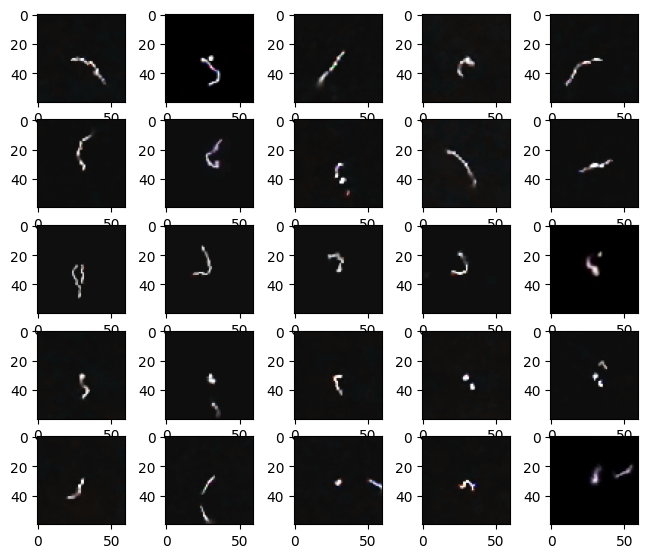

In [6]:
# Plot results
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = int(len(my_ids) / 5) + 1

columns2 = 11
rows2 = int(len(my_ids) / columns2) + 1
ret_img = np.zeros((128 * rows2, 128 * columns2, 3))

xx = 0
yy = 0
for aaa in range(len(my_ids)):
    img_help = cv2.imread('/content/data/' + my_ids[aaa])
    aaa1 = aaa + 1

    ret_img[128 * yy : 128 * (yy + 1), 128 * xx : 128 * (xx + 1), :] = cv2.resize(img_help, (128, 128))
    xx = xx + 1

    if xx > columns2 - 1:
        xx = 0
        yy = yy + 1

    fig.add_subplot(rows, columns, aaa1)
    plt.imshow(img_help)

print(my_cluster_ids)
print(my_ids)

plt.show()